# Load the results of Spike Inference.

In [ ]:
#!pip install rfest
# also need jax and jaxlib installed

In [4]:
import rfest

In [5]:
# --- Phase 3: Tuning Function Fitting ---
# Goal: Load the outputs from the previous notebooks (00 & 02) and use them 
# to estimate the receptive field (RF) for each neuron.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils as U 
import importlib
import os
import glob

# Reload utils to ensure you're using the latest version of your functions
importlib.reload(U) 

print("Starting Phase 3: Tuning Function Fitting...")

# --- Step 1: Load Inputs from Saved Files ---

try:
    # ACTION: Change 'aakarsh' to your namespace if needed.
    namespace = "aakarsh" 
    
    # --- Load the latest output from the preprocessing notebook (00-background.ipynb) ---
    background_dir = f'data/{namespace}/background/'
    list_of_background_files = glob.glob(os.path.join(background_dir, '*.npz'))
    if not list_of_background_files:
        raise FileNotFoundError(f"No background data files found in '{background_dir}'")
    
    latest_background_file = max(list_of_background_files, key=os.path.getctime)
    print(f"Loading latest background data from: {latest_background_file}")
    
    stim_data = np.load(latest_background_file, allow_pickle=True)
    stim_filtered = stim_data['stim_filtered']
    stim_table_filtered_df = pd.DataFrame(stim_data['stim_table_filtered'], columns=stim_data['stim_table_columns'])
    

    # --- Load the latest output from the spike inference notebook (02-spike-inference.ipynb) ---
    spike_inference_dir = f'data/{namespace}/preprocessed/'
    list_of_spike_files = glob.glob(os.path.join(spike_inference_dir, '*.npz'))
    if not list_of_spike_files:
        raise FileNotFoundError(f"No spike inference files found in '{spike_inference_dir}'")
    
    latest_spike_file = max(list_of_spike_files, key=os.path.getctime)
    print(f"Loading latest spike inference data from: {latest_spike_file}")
    
    spike_data = np.load(latest_spike_file, allow_pickle=True)
    print(spike_data.keys())

    inferred_spikes = spike_data['spike_counts']
    time_vector = spike_data['time_vector']
    sampling_rate = spike_data['sampling_frequency']
   
    data  = U.load_data()# Load the latest spike inference data
    data  = U.preprocess_data(data)  # Preprocess the data 

except FileNotFoundError as e:
    print(f"ERROR: Could not find a necessary input file: {e}")
    print("Please ensure you have run the previous notebooks (00 and 02) and saved their outputs correctly.")
    raise

Starting Phase 3: Tuning Function Fitting...
Loading latest background data from: data/aakarsh/background/cleaned_2025_07_16_17_35_52.npz
Loading latest spike inference data from: data/aakarsh/preprocessed/oasis_preprocessed_recordings_2025_07_18_10_16_01.npz
KeysView(NpzFile 'data/aakarsh/preprocessed/oasis_preprocessed_recordings_2025_07_18_10_16_01.npz' with keys: processed_neuron_signal, spike_counts, thresholds, sampling_frequency, time_vector)


Performing initial data preprocessing...
Preprocessing complete.


In [11]:
import importlib
importlib.reload(U)  # Reload utils to ensure you're using the latest version of your functions
locally_sparse_active_mask = U.isolate_sparse_epochs(data, target='locally_sparse_noise')
print(f"Number of active time points for 'locally_sparse_noise': {np.sum(locally_sparse_active_mask)}")
assert 66981 == np.sum(locally_sparse_active_mask), "The number of active time points does not match the expected value."
print(f"Total time points: {len(data['t'])}")
assert 105968 == len(data['t']), "The length of the time vector does not match the expected value."

import utils as U
import importlib
importlib.reload(U)  # Reload utils to ensure you're using the latest version of your functions

active_stim_per_timestep = U.get_active_stimulus_per_timestep(data['stim_table'], total_timesteps=len(data['t']))
assert active_stim_per_timestep[105735] == 8879
assert active_stim_per_timestep[105735] == 8879, "The active stimulus at timestep 105735 does not match the expected value."
assert active_stim_per_timestep[737] == 0
assert active_stim_per_timestep[744] == -1,  "The active stimulus at timestep 737 does not match the expected value."
assert active_stim_per_timestep[745] == 1,  "The active stimulus at timestep 737 does not match the expected value."

# Median frame duration for which a stimulu was presented
frame_durations = np.diff(stim_table_filtered_df["start_s"].values)
avg_frame_duration_s = np.mean(frame_durations)
median_frame_duration_s = np.median(frame_durations)
print(f"Average Frame Duration: {avg_frame_duration_s * 1000:.2f} ms")
print(f"Median Frame Duration: {median_frame_duration_s * 1000:.2f} ms")
print(f"Stimulus Frame Rate: {frame_rate_hz:.2f} Hz")
print(f"stim_data['t_filtered'].shape: {stim_data['t_filtered'].shape}")
print(f"stim_data['dff_filtered'].shape: {stim_data['dff_filtered'].shape}")
print(f"stim_data['running_seed_filtered'].shape: {stim_data['running_speed_filtered'].shape}")
print(f"stim_data['stim_filtered'].shape: {stim_data['stim_filtered'].shape}")
print(f"stim_data['stim_table_table_filtered'].shape: {stim_data['stim_table_filtered'].shape}")
print(f"stim_table_columns.shape: {stim_data['stim_table_columns'].shape}")

Number of active time points for 'locally_sparse_noise': 66981
Total time points: 105968
Mapping active stimulus frame to each timestep...
Mapping complete.
Average Frame Duration: 12.46 ms
Median Frame Duration: 8.00 ms
Stimulus Frame Rate: 80.28 Hz
stim_data['t_filtered'].shape: (1760,)
stim_data['dff_filtered'].shape: (189, 1760)
stim_data['running_seed_filtered'].shape: (2, 1760)
stim_data['stim_filtered'].shape: (7739, 16, 28)
stim_data['stim_table_table_filtered'].shape: (7739, 5)
stim_table_columns.shape: (5,)


In [14]:
importlib.reload(U)  # Reload utils to ensure you're using the latest version of your functions
inferred_spikes = spike_data['spike_counts']
# binned_spikes.shape, presented_frame_ids.shape
binned_spikes, presented_frame_ids = \
    U.bin_spikes_to_frames_from_active_stim_per_timestep(inferred_spikes, active_stim_per_timestep)

Binning spikes using timestep-to-frame mapping array...
Binning complete. Binned spikes shape: (189, 8880)


In [15]:
# Prepare the stimulus matrix from the presented frame IDs
importlib.reload(U)  # Reload utils to ensure you're using the latest version of your functions

flattened_stim, stim_h, stim_w = \
    U.prepare_stimulus_matrix_from_ids(presented_frame_ids, full_stim_movie=data['stim'])

Preparing stimulus matrix from frame IDs...
Stimulus matrix preparation complete. Shape: (448, 8880)


In [16]:
# Convert the stimulus to binary matrices for 'ON' and 'OFF' stimuli, these are easier to train and give better receptive field estimates.

# Create a copy of the original flattened stimulus matrix
flattened_on_stimuli = flattened_stim.copy()
flattened_off_stimuli = flattened_stim.copy()

# For the 'ON' matrix, set all 'OFF' pixels (<= 127) to zero
flattened_on_stimuli[flattened_on_stimuli <= 127] = 0
flattened_on_stimuli[flattened_on_stimuli > 127] = 1

# For the 'OFF' matrix, set all 'ON' pixels (> 127) to zero
flattened_off_stimuli[flattened_off_stimuli < 127] = 1
flattened_off_stimuli[flattened_off_stimuli >= 127] = 0

# --- Verification ---
print(f"Flattened Stimulus Shape: {flattened_stim.shape}")
print(f"Flattened On Stimuli Shape: {flattened_on_stimuli.shape}")
print(f"Flattened Off Stimuli Shape: {flattened_off_stimuli.shape}")

# These assertions will now pass because the shape is preserved
assert flattened_on_stimuli.shape == flattened_stim.shape, "The shape of flattened_on_stimuli does not match the shape of flattened_stim."
assert flattened_off_stimuli.shape == flattened_stim.shape, "The shape of flattened_off_stimuli does not match the shape of flattened_stim."

print("\nAssertions passed! The shapes are now correct.")

Flattened Stimulus Shape: (448, 8880)
Flattened On Stimuli Shape: (448, 8880)
Flattened Off Stimuli Shape: (448, 8880)

Assertions passed! The shapes are now correct.


# Look at Spline based models



binned_spikes.shape: (189, 8880)
flattened_stim_for_rfest.shape: (448, 8880)
dims: (20, 16, 28)


In [ ]:
from rfest import splineLNP
from rfest import build_design_matrix


w_est_spline_coeffs = []
for neuron_idx in range(binned_spikes.shape[0]):
    neuron_to_fit = neuron_idx 
    print(f"binned_spikes.shape: {binned_spikes.shape}")
    neuron_binned_spikes = binned_spikes[neuron_to_fit,: ]
    flattened_stim_for_rfest = flattened_on_stimuli.copy()
    print(f"flattened_stim_for_rfest.shape: {flattened_stim_for_rfest.shape}")
    num_lags = 20  # Number of lags to consider for the GLM
    dims = (num_lags, stim_h, stim_w)
    print(f"dims: {dims}")
    df = (8, 8, 12) # (time, height, width)


    X_design = build_design_matrix(flattened_stim_for_rfest.T, nlag=num_lags)
    # Remove the first num_lags-1 entries from the binned spikes to match the response length
    y_response = neuron_binned_spikes

    print(f"X_design.shape: {X_design.shape}")

    print(f"X_design.shape: {X_design.shape}")
    print(f"y_response.shape: {y_response.shape}")
    model = splineLNP(X_design, y_response, dims=dims, df=df)
    print(f"Model initialized for Neuron {neuron_to_fit} with dims: {dims} and df: {df}")
    # Fit the model. This performs the optimization.
    print(f"Fitting splineLNP model for Neuron {neuron_to_fit}...")
    model.fit(beta=0.01, num_iters=200, verbose=10)

    # The estimated receptive field is stored in model.w_opt
    w_est_spline = model.w_opt
    w_est_spline_coeffs.append(w_est_spline)
    print(f"\n Neuron {neuron_to_fit} Fitting complete!")


X_design.shape: (8880, 8960)
X_design.shape: (8880, 8960)
y_response.shape: (8880,)
Fitting splineLNP model for Neuron 32...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            0.881        9300.537        
10           1.017        8603.843        
20           1.155        8154.994        
30           1.279        7796.461        
40           1.410        7448.652        
50           1.536        7114.674        
60           1.665        6791.213        
70           1.794        6472.586        
80           1.928        6158.174        
90           2.055        5847.253        
100          2.187        5539.650        
110          2.312        5235.647        
120          2.444        4935.759        
130          2.570        4640.694        
140          2.700        4351.187        
150          2.827        4067.897        
160          2.957        3791.364        
170          3.084        3522.002        
180          3.223        

In [53]:
print(w_est_spline.shape)
print(w_est_spline[0].shape)


(8960,)
()



Visualizing results for an example neuron (Neuron 32 (Spline Fit))...


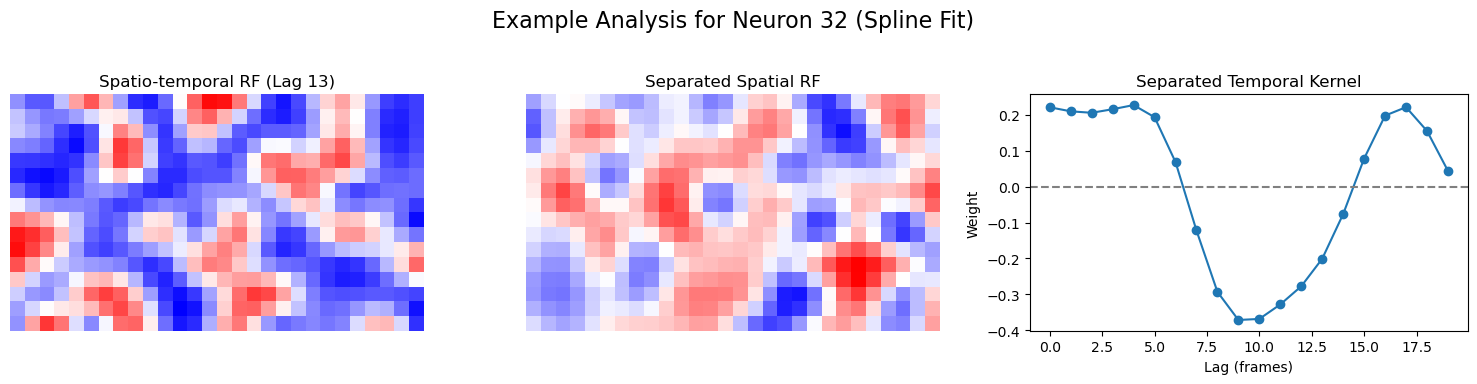

In [ ]:
# Reshape the flattened w_est back into its spatio-temporal form
strf_spline = w_est_spline.reshape(dims)

# To use our existing visualization function, we need to reshape the STRF
# from (time, height, width) to (pixels, time) and extract the spatial component.
num_pixels = stim_h * stim_w
strf_for_vis = strf_spline.transpose(1, 2, 0).reshape(num_pixels, num_lags)

# Use SVD to get the separable spatial component for plotting.
from scipy.linalg import svd
U_spl, _, _ = svd(strf_for_vis - strf_for_vis.mean(axis=1, keepdims=True), full_matrices=False)
spatial_rf_spline = U_spl[:, 0].reshape(stim_h, stim_w)


U.visualize_neuron_rf( neuron_id=f"{neuron_to_fit} (Spline Fit)", 
                        spatiotemporal_rf=strf_for_vis, 
                        spatial_rf=spatial_rf_spline, 
                        delta=range(num_lags))

In [ ]:
splineLNP(
    dims=flattened_on_stimuli.shape[1],
    df=flattened_on_stimuli.shape[0],
    X=flattened_on_stimuli,
    y=binned_spikes,
    dt=1.0,  # Assuming 1 second time step
    n_spline=10,  # Number of spline basis functions
    n_lags=5,  # Number of lags to consider
    fit_intercept=True,  # Whether to fit an intercept term
    max_iter=1000,  # Maximum number of iterations for optimization
    tol=1e-4,  # Tolerance for convergence
    verbose=True  # Print progress during fitting
)

TypeError: splineLNP.__init__() missing 2 required positional arguments: 'dims' and 'df'

In [ ]:
import importlib
importlib.reload(U)  # Reload utils to ensure you're using the latest version of your functions

lags_to_test= range(15) 
selected_neurons = [32, 38, 87, 89,94, 104,113, 114, 144, 174,179]
all_rfs_spatiotemporal_off = U.fit_all_neurons_rfs(binned_spikes, flattened_off_stimuli, lags_to_test, selected_neurons=selected_neurons)


Step 3 & 4: Fitting spatio-temporal receptive fields for all neurons...
  Fitting Neuron 33/189...
  Fitting Neuron 39/189...
  Fitting Neuron 88/189...
  Fitting Neuron 90/189...
  Fitting Neuron 95/189...
  Fitting Neuron 105/189...
  Fitting Neuron 114/189...
  Fitting Neuron 115/189...
  Fitting Neuron 145/189...
  Fitting Neuron 175/189...
  Fitting Neuron 180/189...
Fitting complete.


In [99]:
import importlib
importlib.reload(U)  # Reload utils to ensure you're using the latest version of your functions
lags_to_test= range(15) 
selected_neurons = [32, 38, 87, 89,94, 104,113, 114, 144, 174,179]
all_rfs_spatiotemporal_on = U.fit_all_neurons_rfs(binned_spikes, flattened_on_stimuli, lags_to_test, selected_neurons=selected_neurons)


Step 3 & 4: Fitting spatio-temporal receptive fields for all neurons...
  Fitting Neuron 33/189...
  Fitting Neuron 39/189...
  Fitting Neuron 88/189...
  Fitting Neuron 90/189...
  Fitting Neuron 95/189...
  Fitting Neuron 105/189...
  Fitting Neuron 114/189...
  Fitting Neuron 115/189...
  Fitting Neuron 145/189...
  Fitting Neuron 175/189...
  Fitting Neuron 180/189...
Fitting complete.


In [ ]:
# --- Step 2: Run the Receptive Field Fitting Pipeline ---
# 2a. Bin the inferred spikes to align them with the stimulus frames
# binned_spikes = U.bin_spikes_to_frames(inferred_spikes, t_filtered, stim_table_filtered_df)

# 2b. Prepare the stimulus matrix by flattening the frames
# flattened_stim, stim_h, stim_w = U.prepare_stimulus_matrix(stim_filtered)

# 2c. Define the time lags and fit the STRF for all neurons
#lags_to_test = [0, 1, 2, 3, 4] # Using 5 lags as in your CodingLab5
#all_rfs_spatiotemporal = U.fit_all_neurons_rfs(binned_spikes, flattened_stim, lags_to_test)



Step 5: Separating spatial and temporal components using SVD...
SVD analysis complete. Extracted 189 spatial receptive fields.

Receptive field fitting and analysis complete!


In [100]:
# Save the all_rfs_spatial to a file for later use
from datetime import datetime

output_dir = f'data/{namespace}/receptive_fields/'
os.makedirs(output_dir, exist_ok=True)
run_date_prefix_current_time = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
output_file = os.path.join(output_dir, f'all_rfs_spatial_{run_date_prefix_current_time}.npz')

np.savez(output_file, all_rfs_spatial=all_rfs_spatial, stim_h=stim_h, stim_w=stim_w)
print(f"Receptive fields saved to: {output_file}")

Receptive fields saved to: data/aakarsh/receptive_fields/all_rfs_spatial_2025_07_18_20_37_46.npz


In [101]:
# 2d. Extract the primary spatial component from each STRF using SVD
all_rfs_spatial = U.extract_spatial_rfs_svd(all_rfs_spatiotemporal, stim_h, stim_w)
print("\nReceptive field fitting and analysis complete!")


Step 5: Separating spatial and temporal components using SVD...
SVD analysis complete. Extracted 11 spatial receptive fields.

Receptive field fitting and analysis complete!



Generating detailed STRF visualization for Neuron 0...


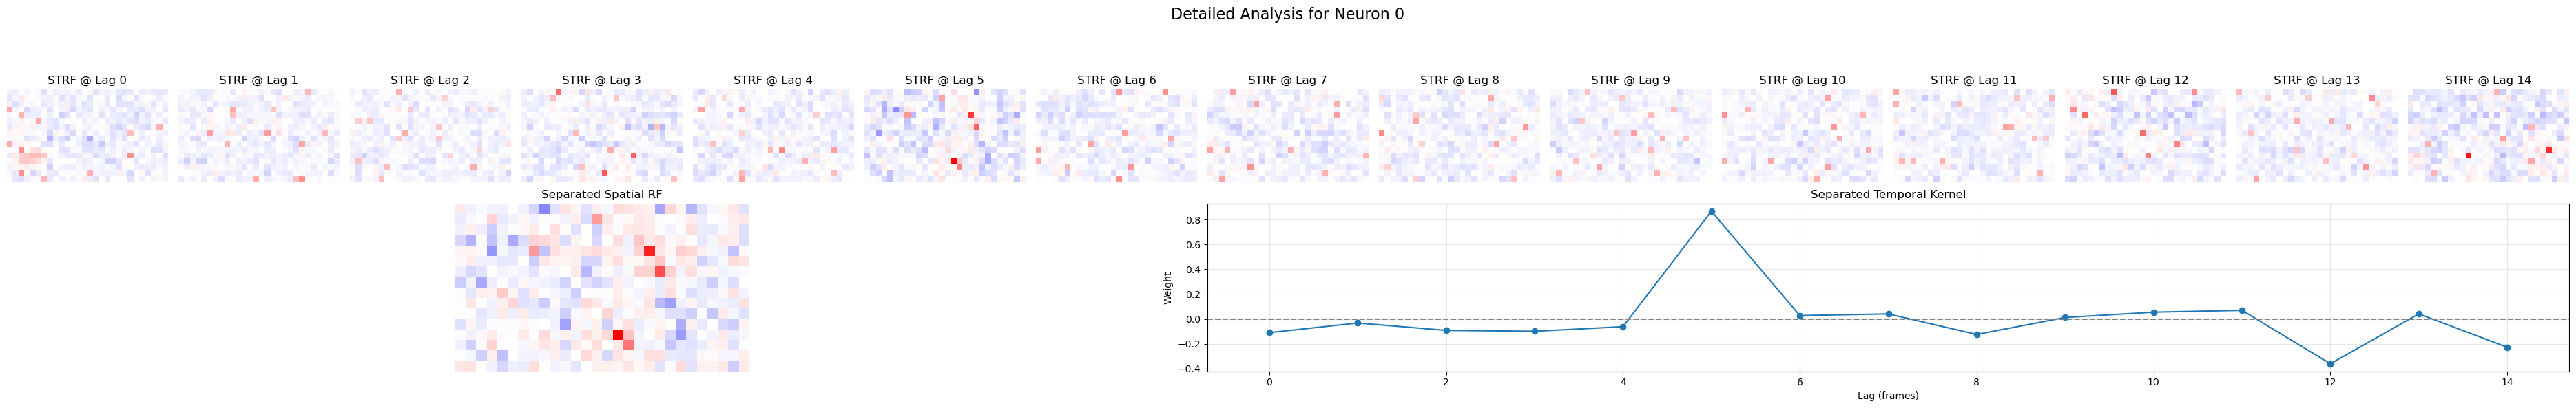


Generating detailed STRF visualization for Neuron 0...


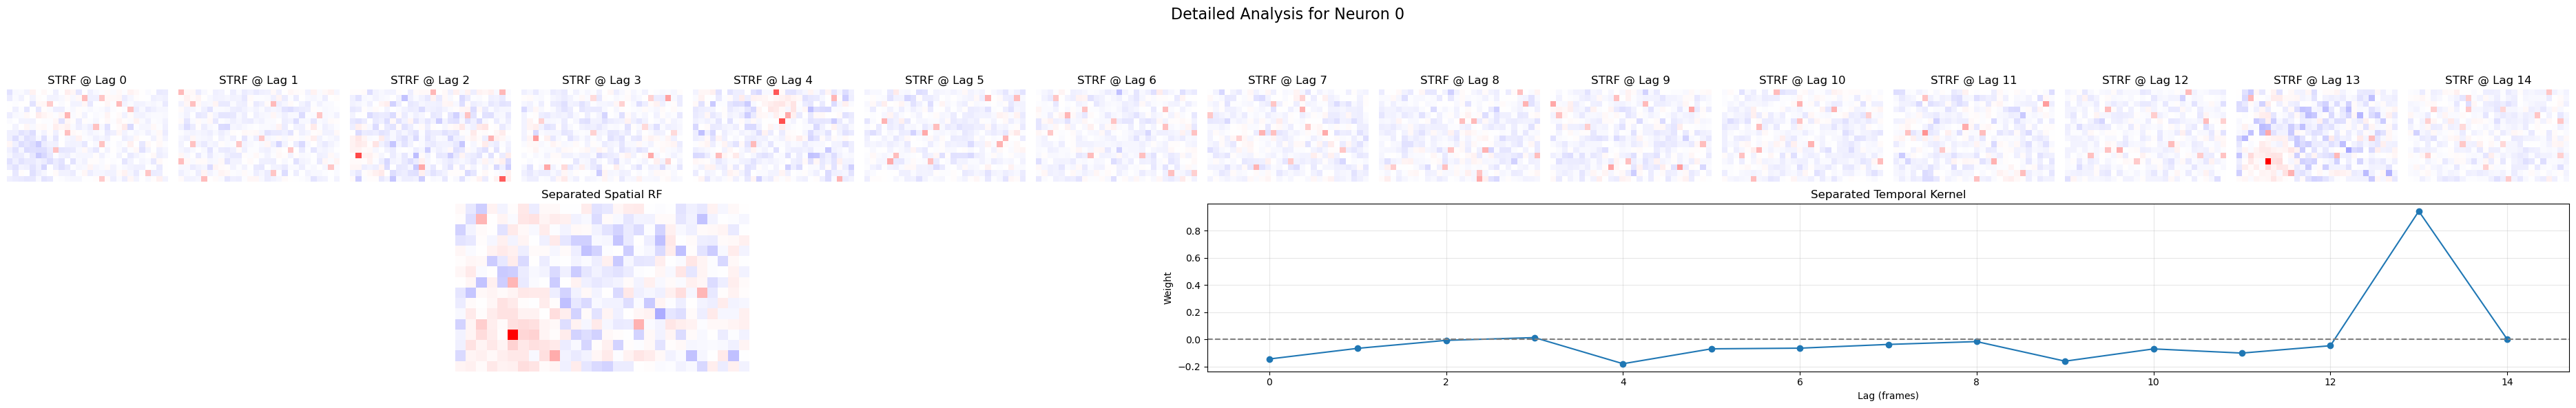


Generating detailed STRF visualization for Neuron 1...


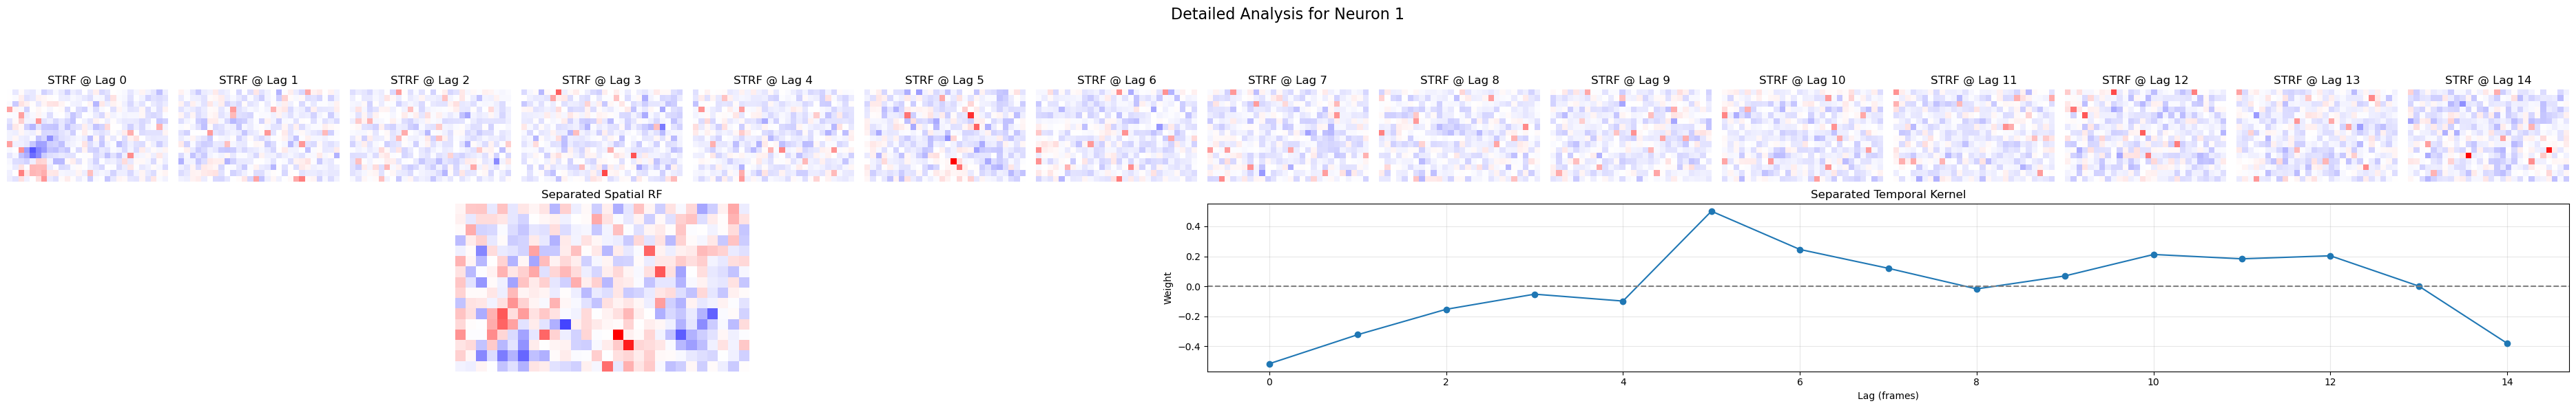


Generating detailed STRF visualization for Neuron 1...


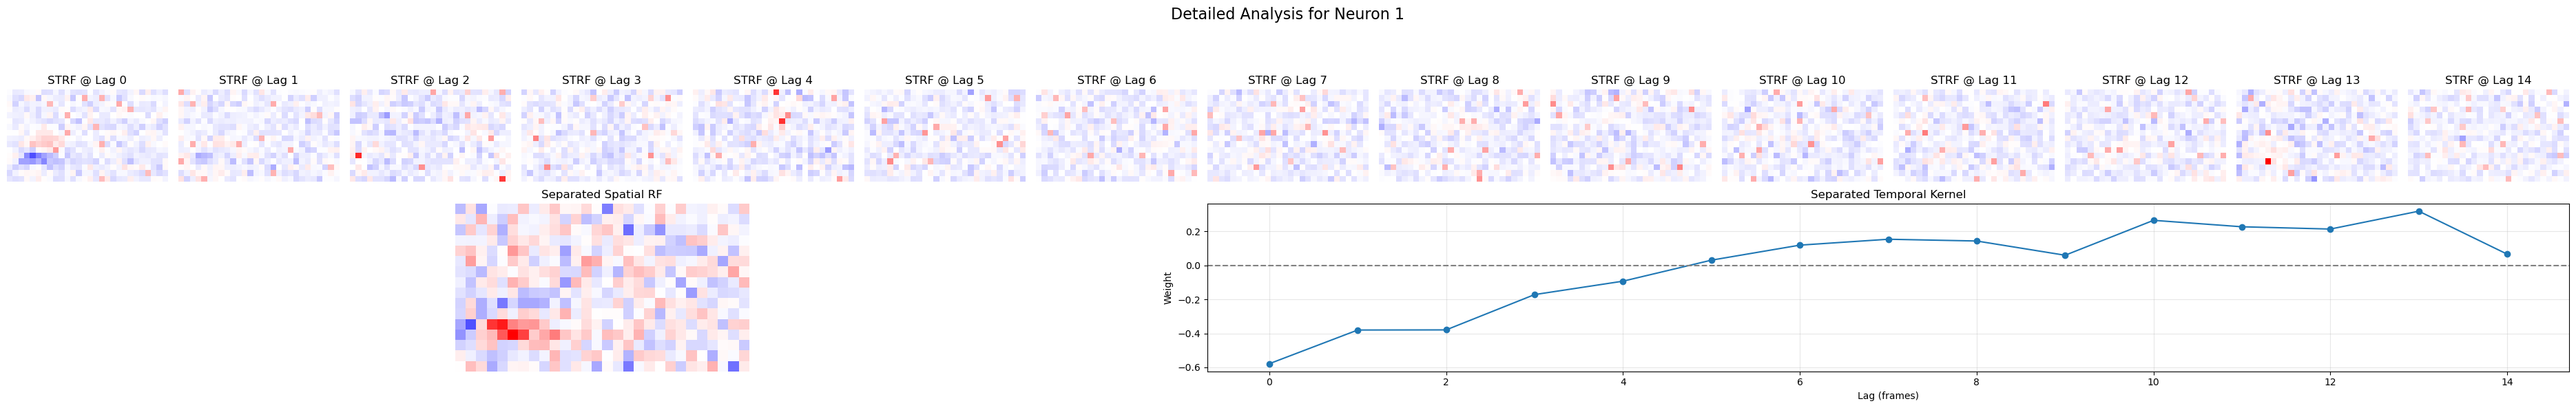


Generating detailed STRF visualization for Neuron 2...


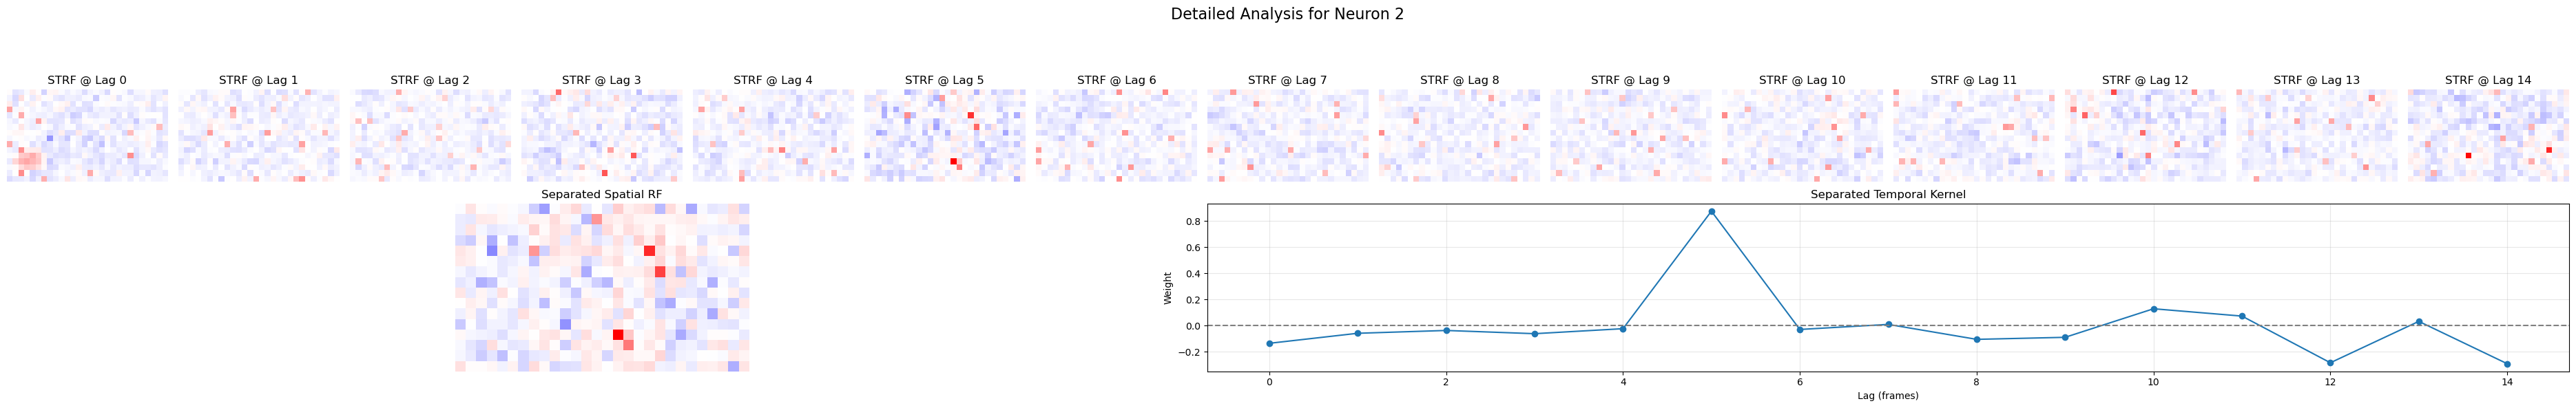


Generating detailed STRF visualization for Neuron 2...


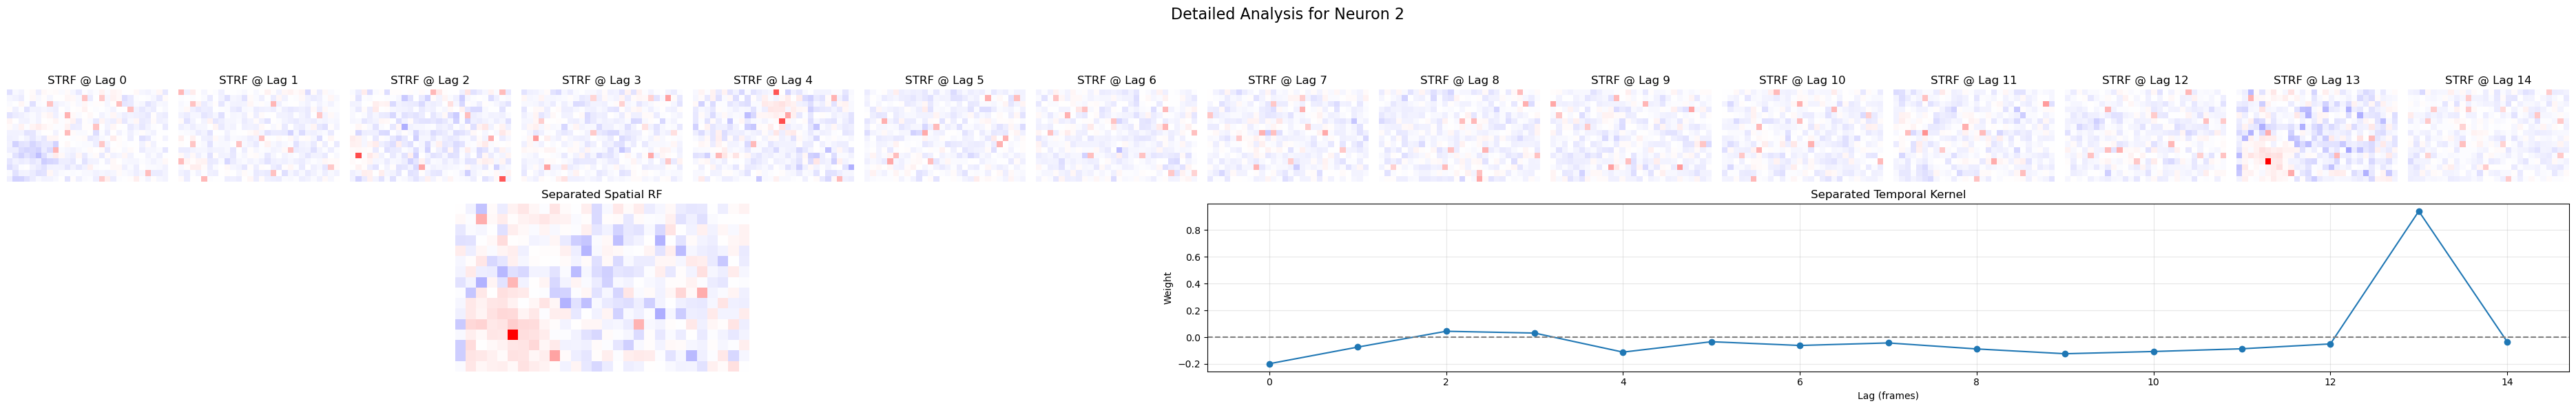


Generating detailed STRF visualization for Neuron 3...


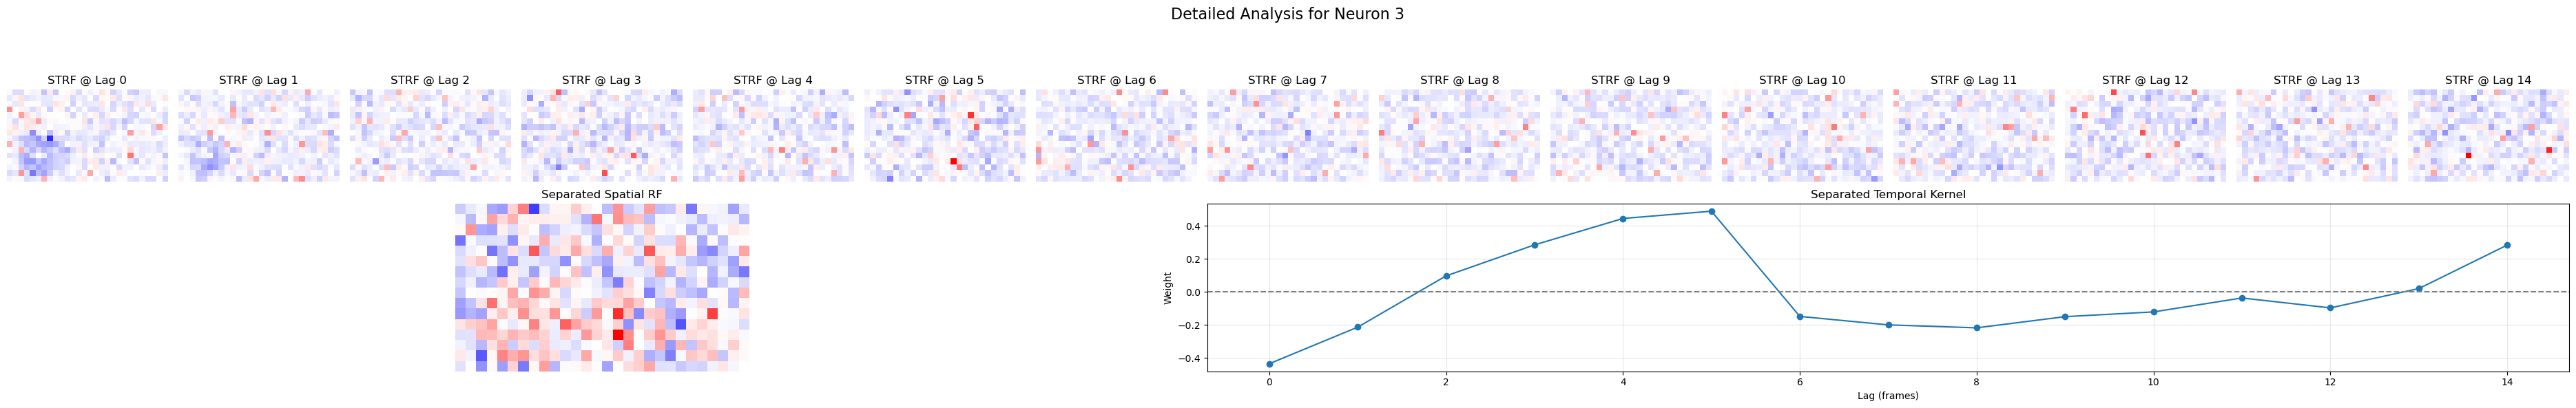


Generating detailed STRF visualization for Neuron 3...


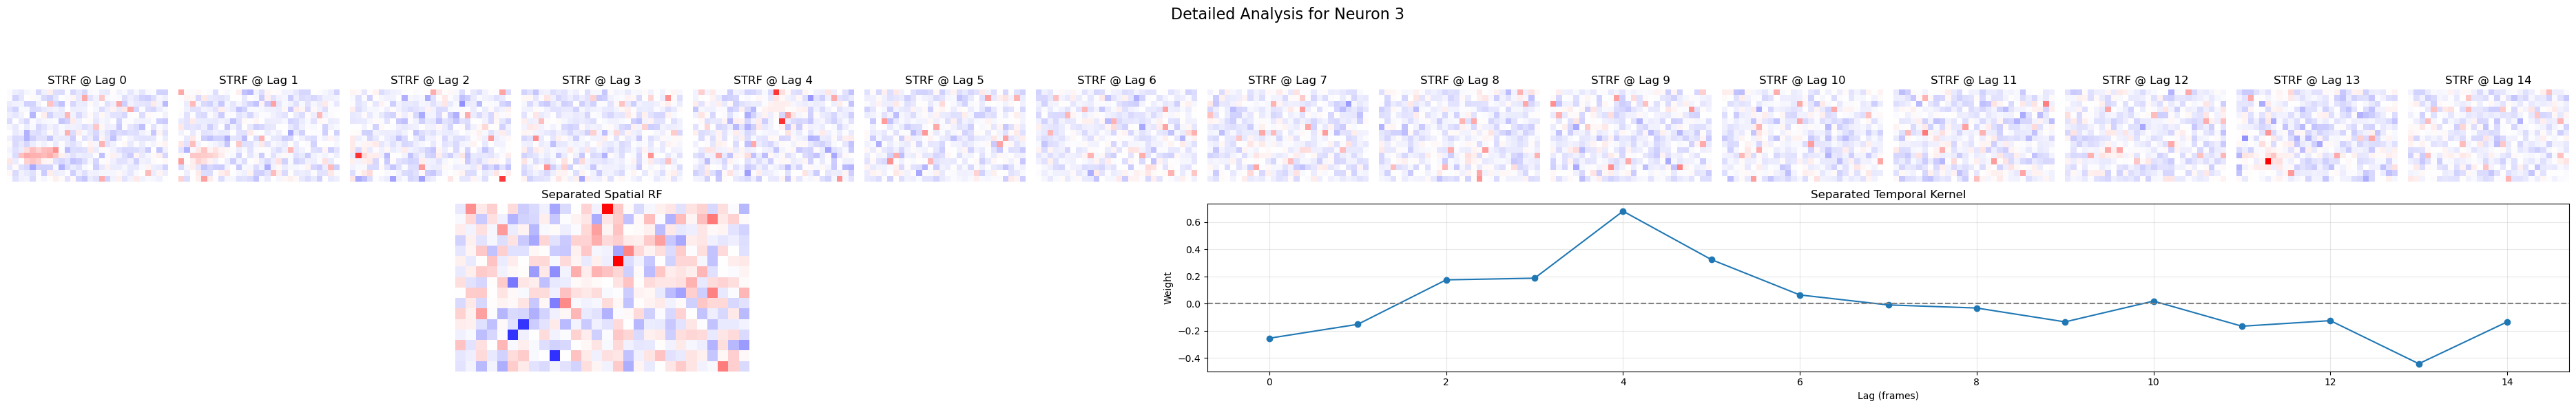


Generating detailed STRF visualization for Neuron 4...


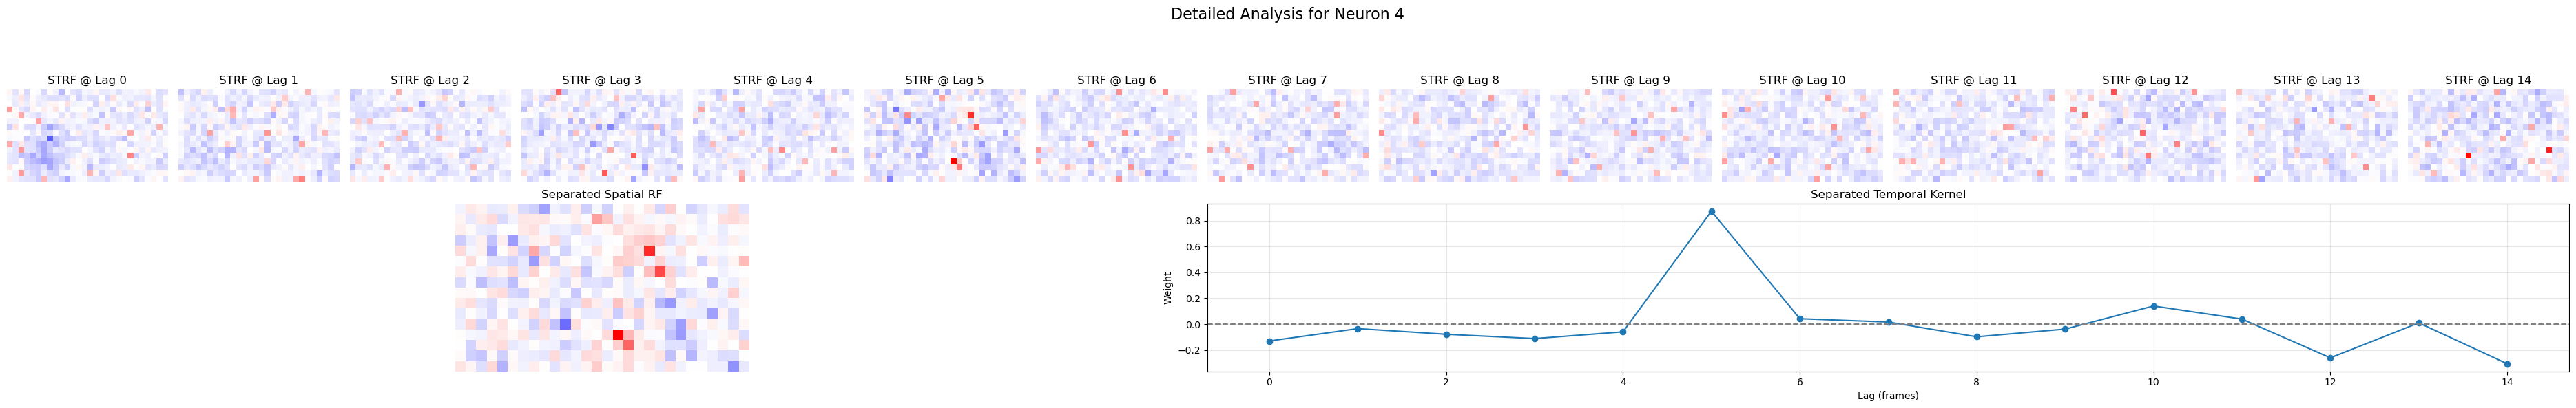


Generating detailed STRF visualization for Neuron 4...


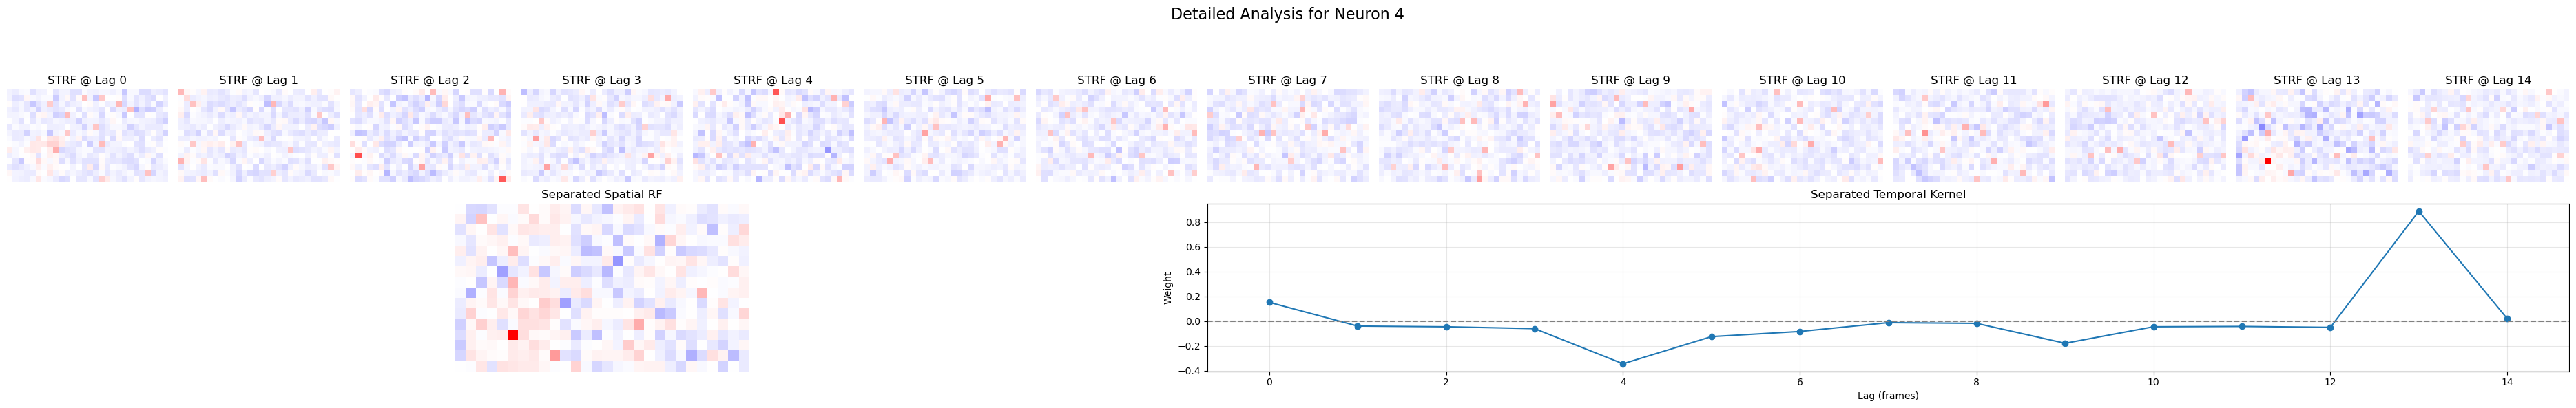


Generating detailed STRF visualization for Neuron 5...


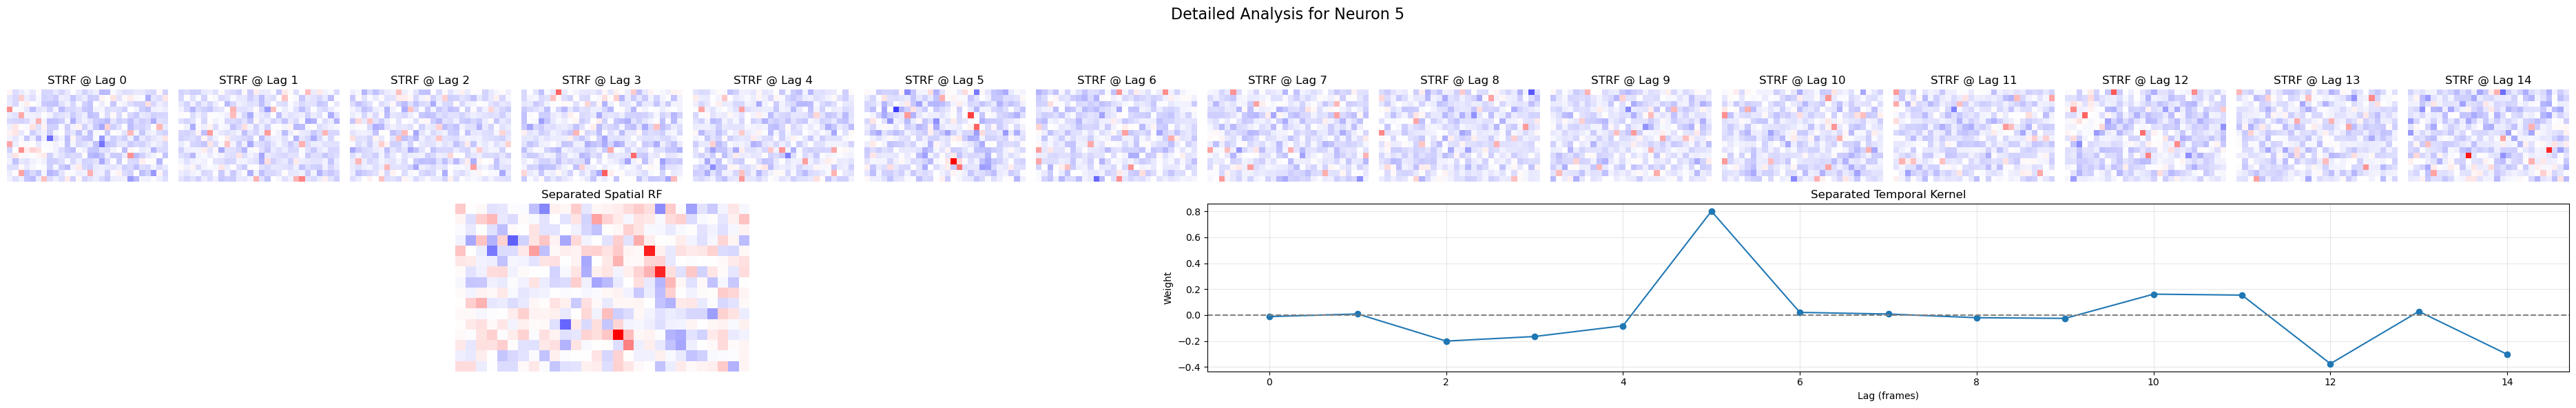


Generating detailed STRF visualization for Neuron 5...


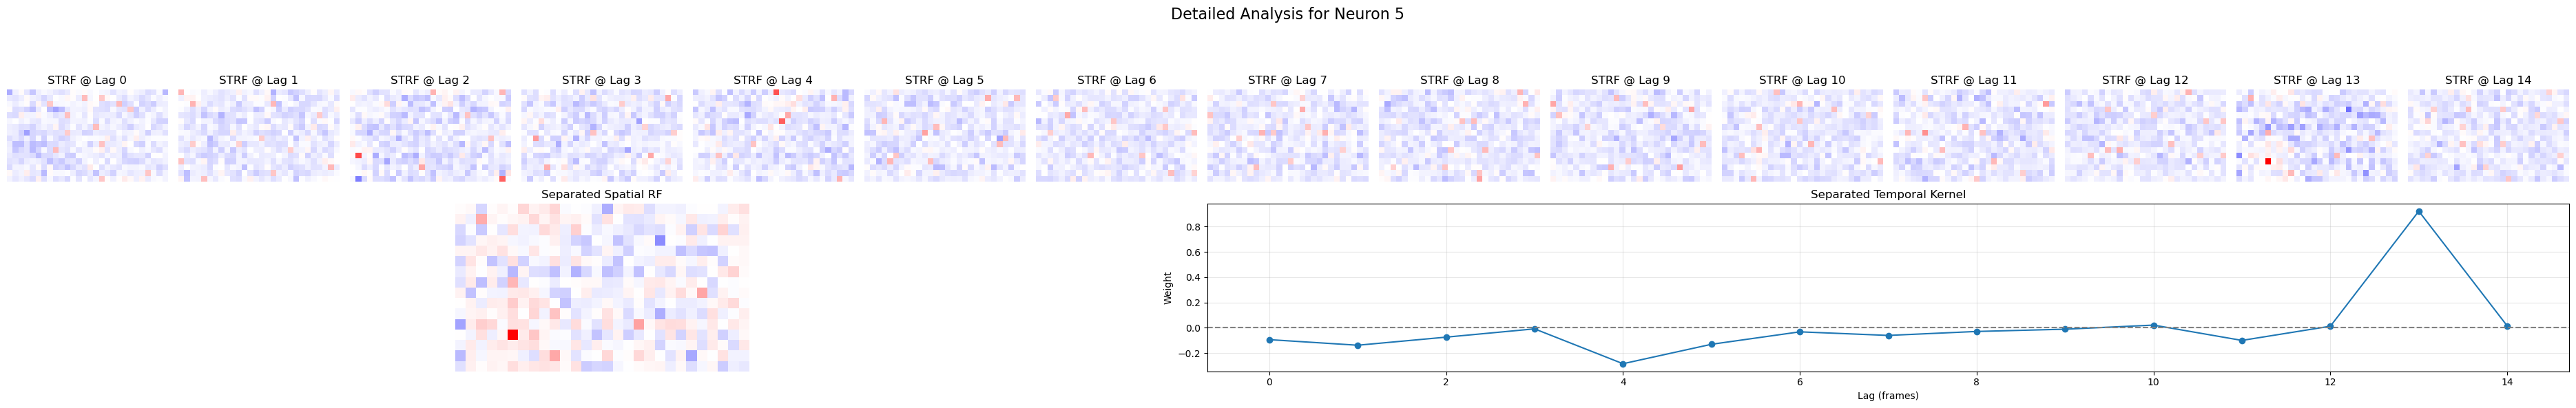


Generating detailed STRF visualization for Neuron 6...


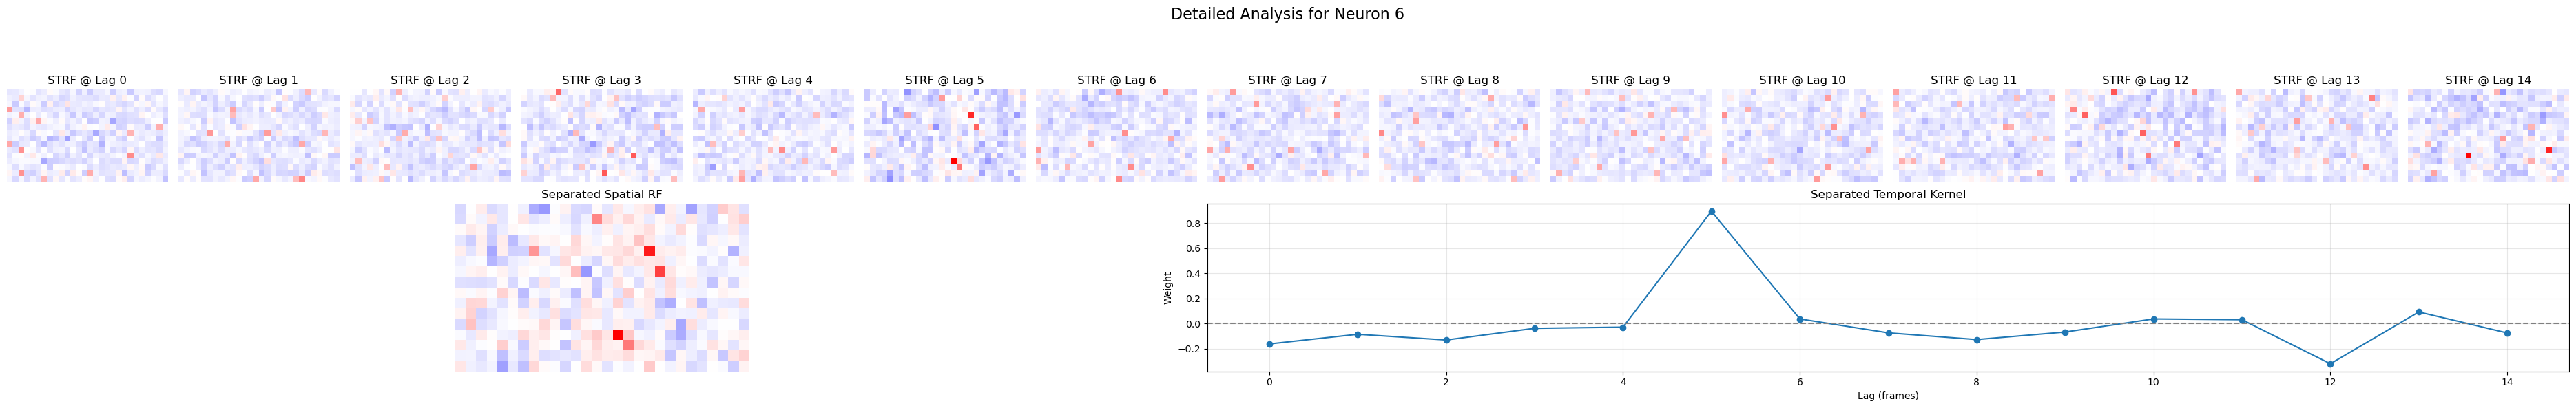


Generating detailed STRF visualization for Neuron 6...


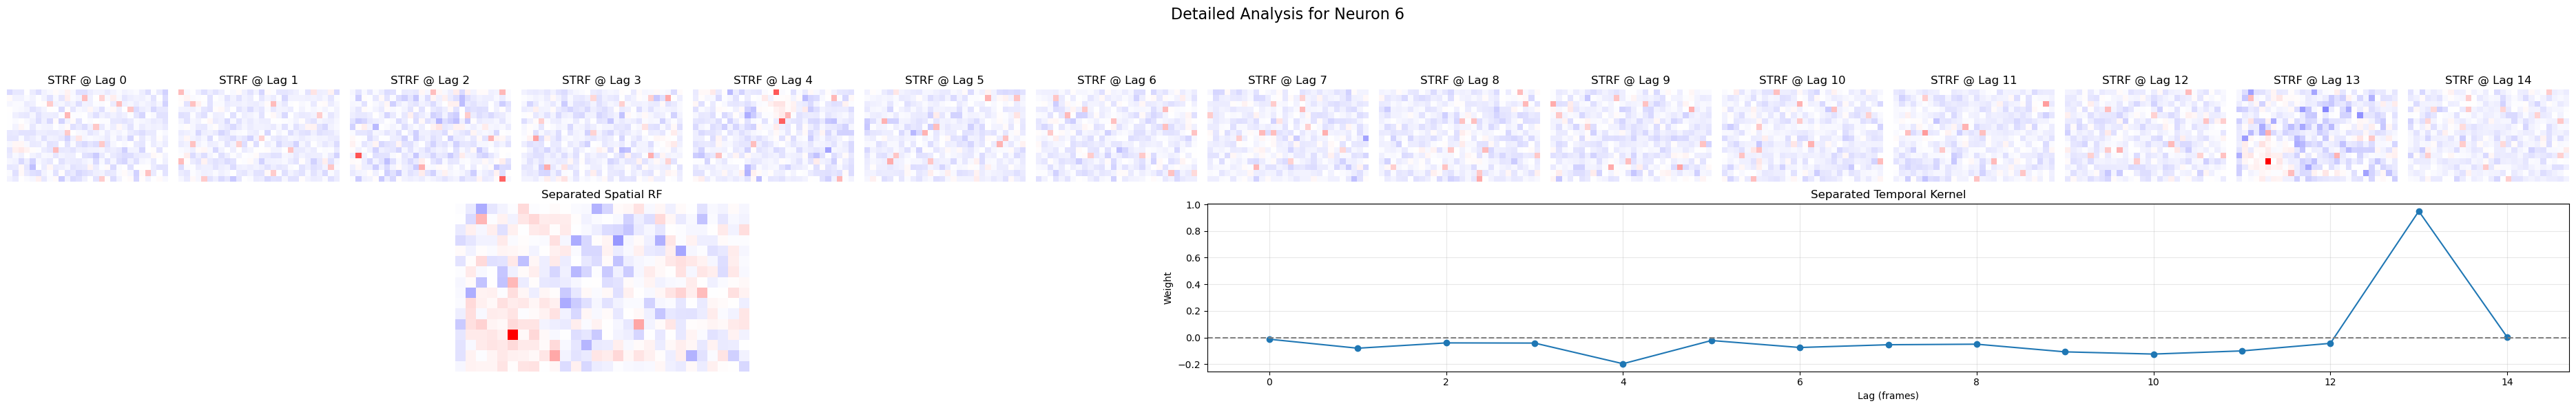


Generating detailed STRF visualization for Neuron 7...


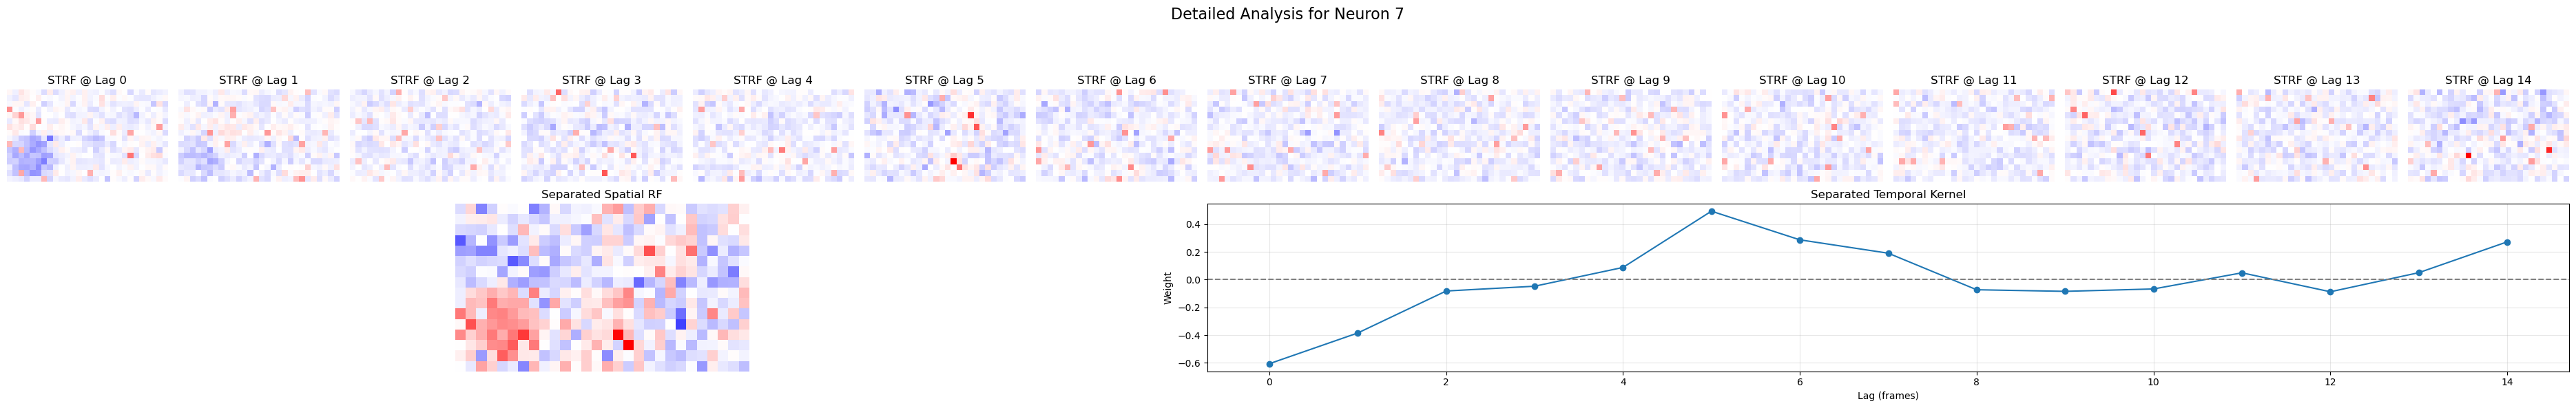


Generating detailed STRF visualization for Neuron 7...


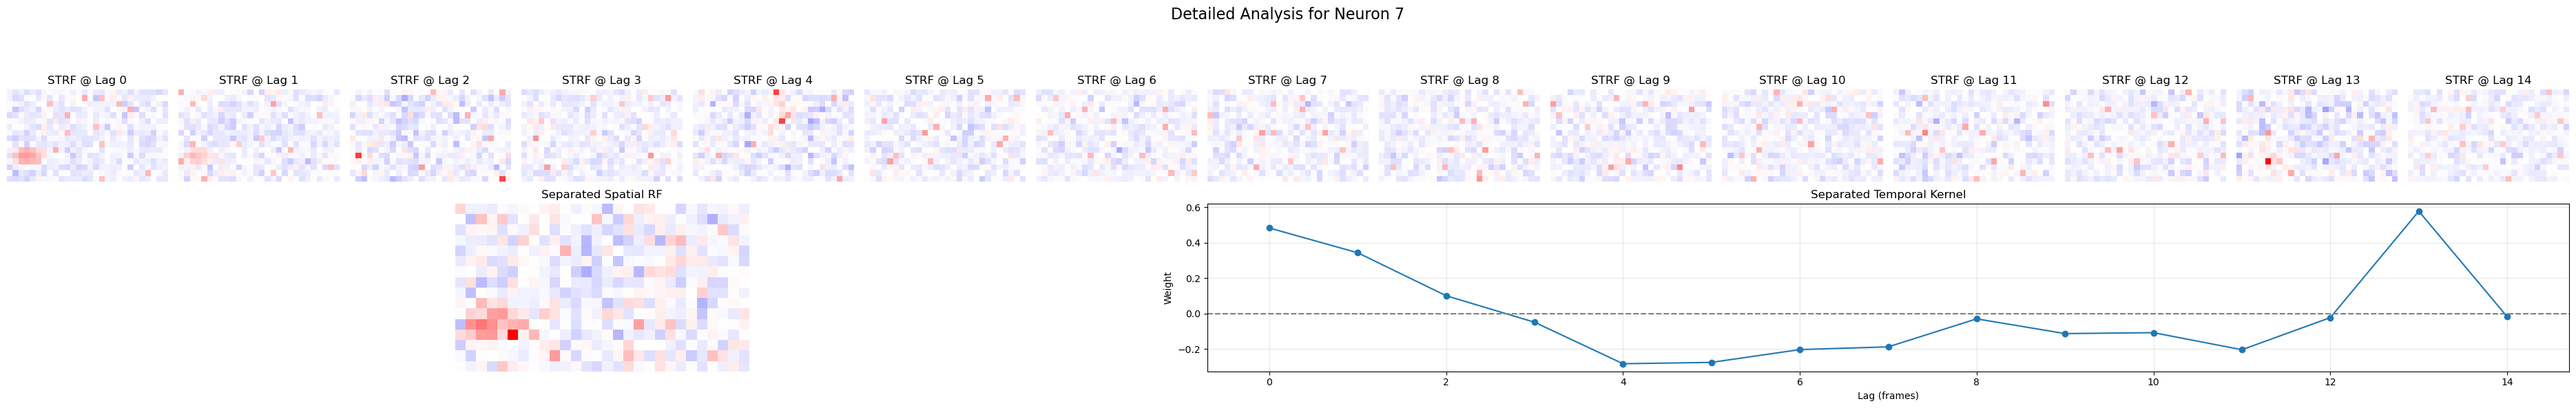


Generating detailed STRF visualization for Neuron 8...


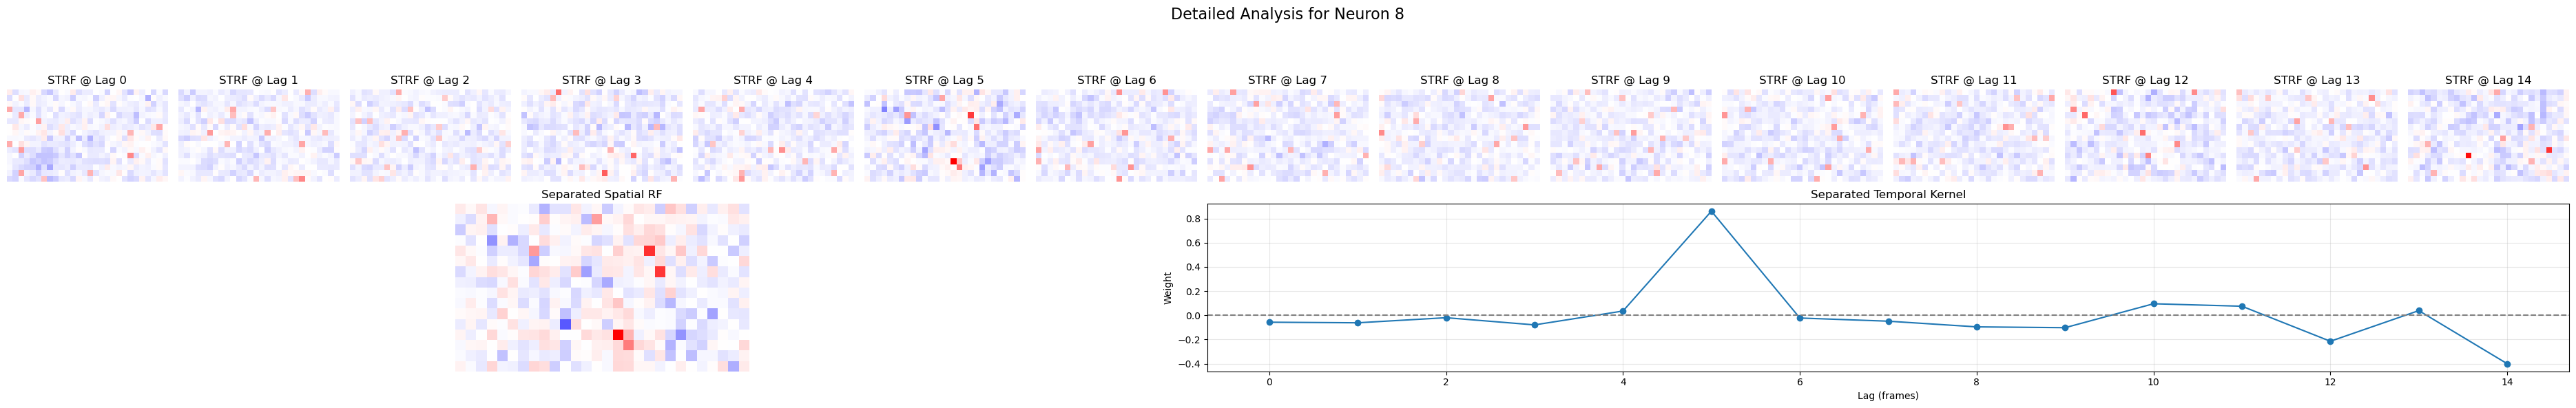


Generating detailed STRF visualization for Neuron 8...


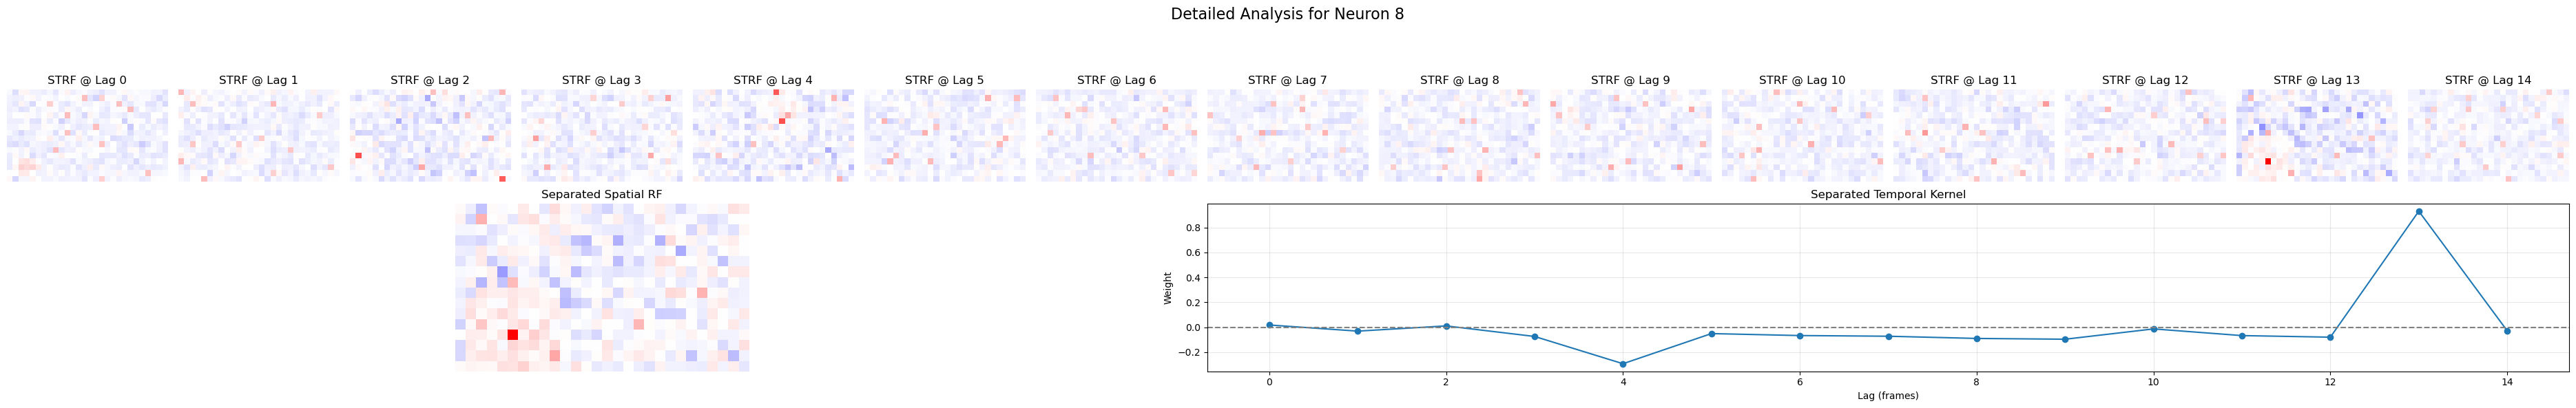


Generating detailed STRF visualization for Neuron 9...


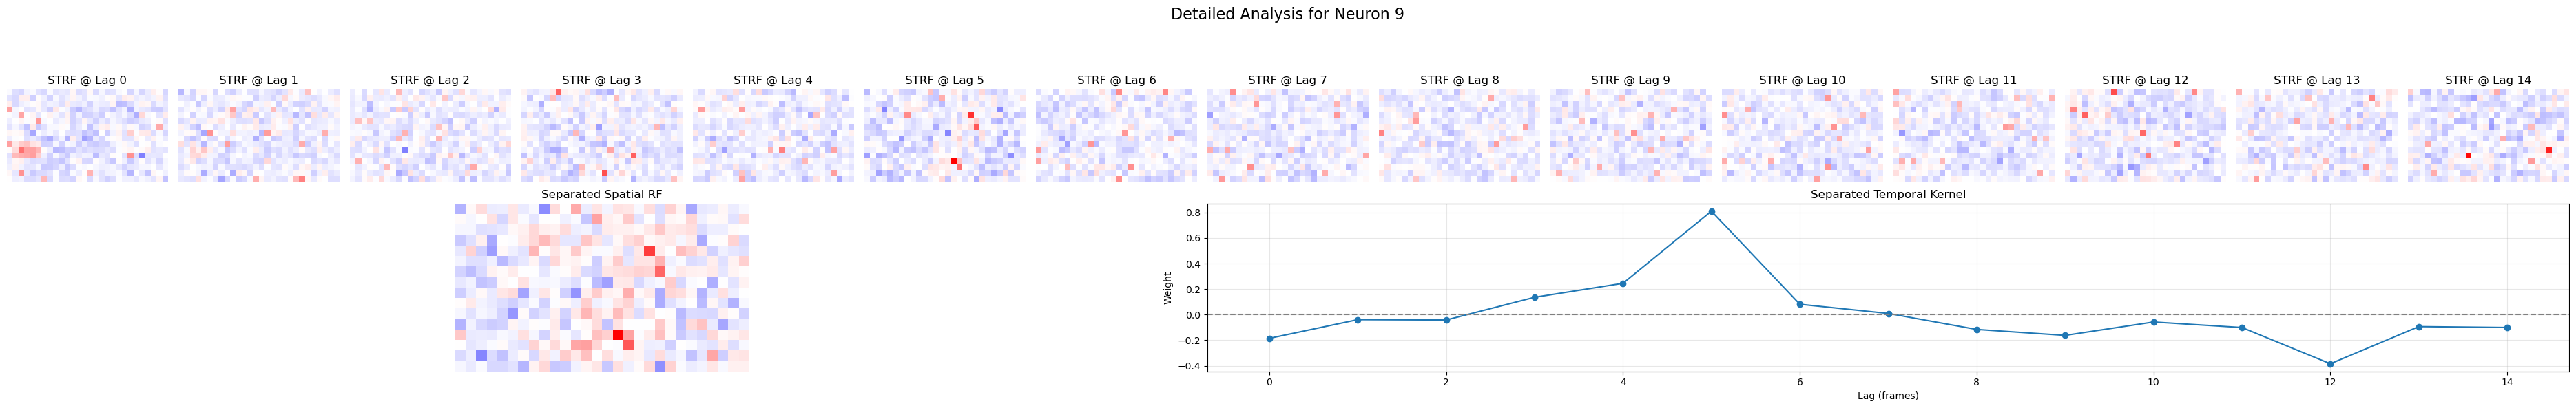


Generating detailed STRF visualization for Neuron 9...


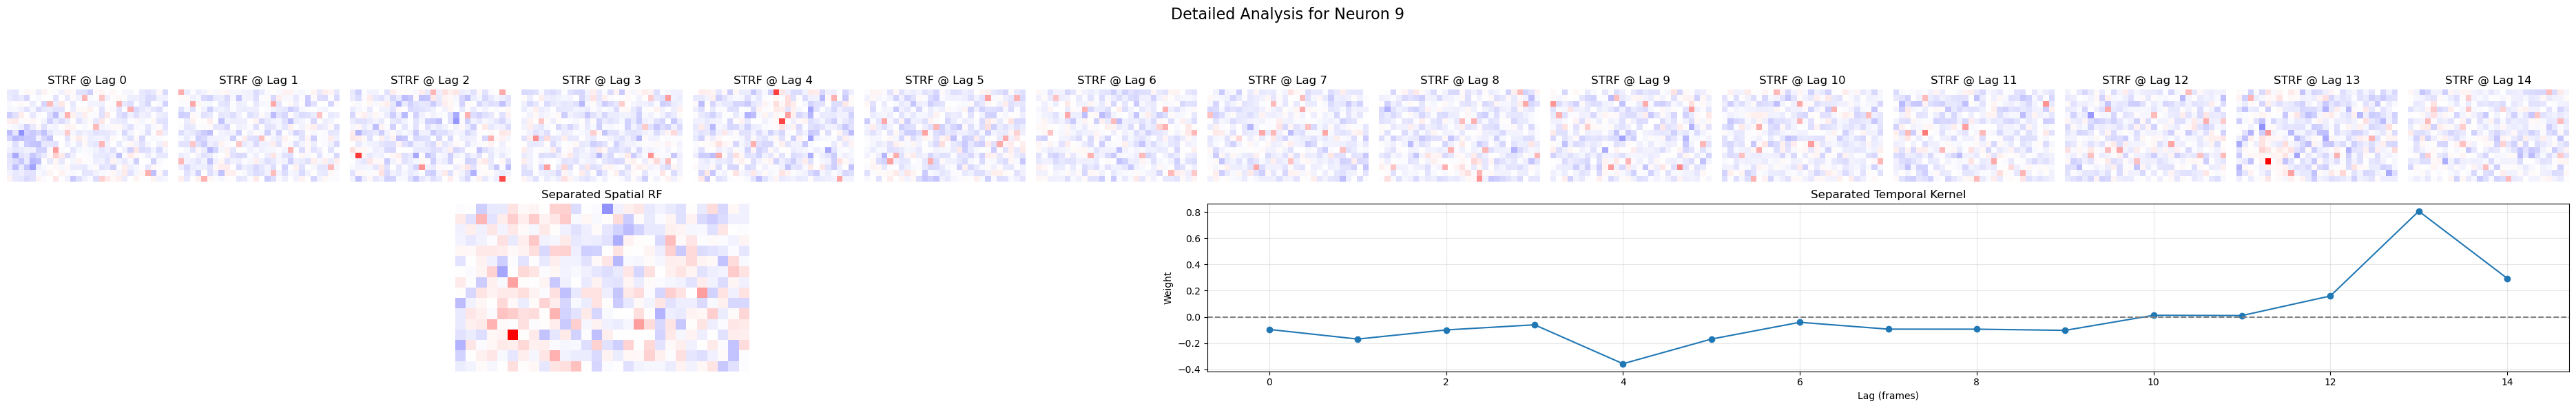


Generating detailed STRF visualization for Neuron 10...


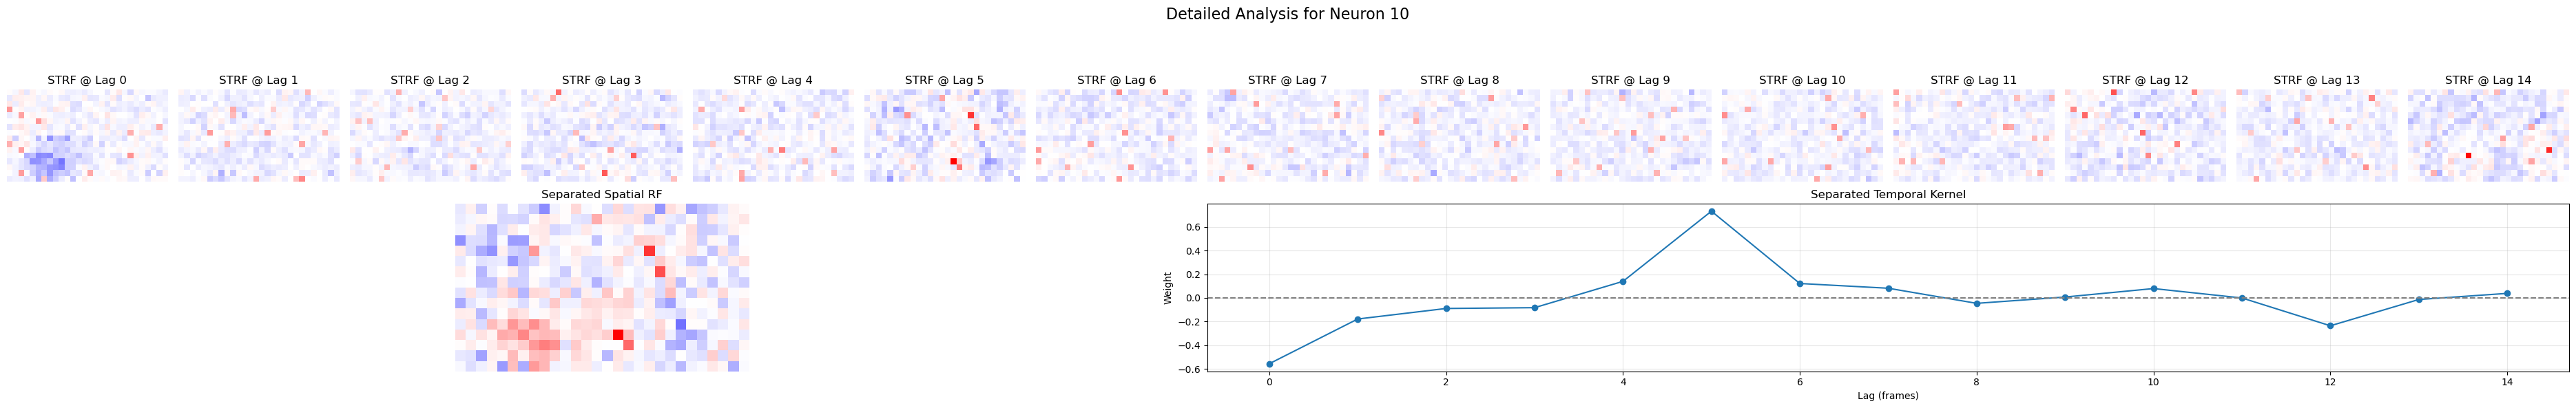


Generating detailed STRF visualization for Neuron 10...


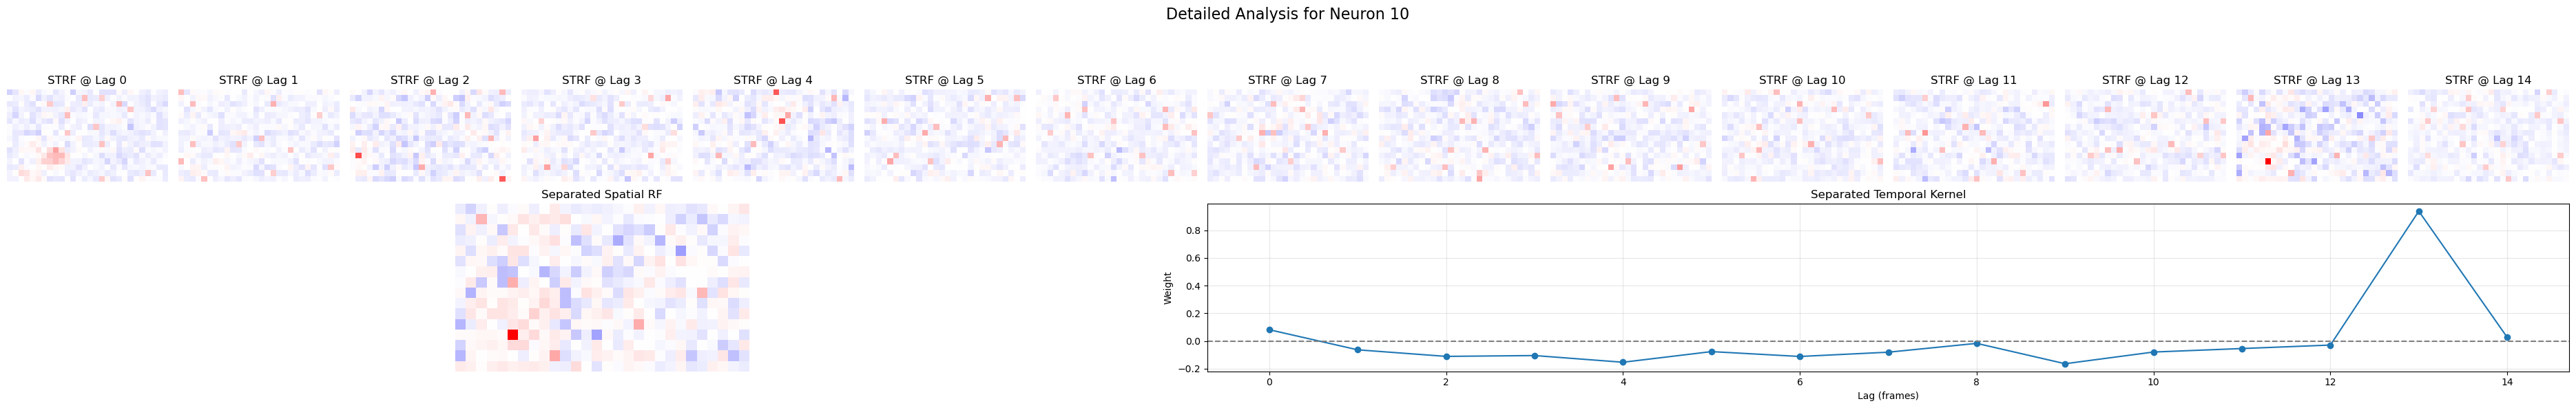

In [ ]:
# --- Step 3: Verification Plot ---
# Check 5 random neurons to verify the RF fitting
import utils as U
import importlib 

importlib.reload(U)  # Reload utils to ensure you're using the latest version of your functions

#neurons_to_check = np.random.choice(range(len(all_rfs_spatiotemporal)), num_neurons_to_check, replace=False)
neurons_to_check = range(len(all_rfs_spatiotemporal))  # Check all neurons for now
for neuron_id in neurons_to_check:
    U.visualize_neuron_strf_details(
        neuron_id=neuron_id,
        spatiotemporal_rf=all_rfs_spatiotemporal_on[neuron_id],
        delta=lags_to_test,
        stim_dims=(stim_h, stim_w)
    )
    U.visualize_neuron_strf_details(
        neuron_id=neuron_id,
        spatiotemporal_rf=all_rfs_spatiotemporal_off[neuron_id],
        delta=lags_to_test,
        stim_dims=(stim_h, stim_w)
    ) 

Starting Phase 4: Final Analysis and Visualization...
Loading latest RF fitting data from: data/aakarsh/rf_fitting/neuron_rf_2025_07_16_20_47_22.npz
Calculating centroids of ROI masks...
ROI centroid calculation complete.
Calculating centers of spatial receptive fields...
RF center calculation complete.

Generating retinotopic maps...


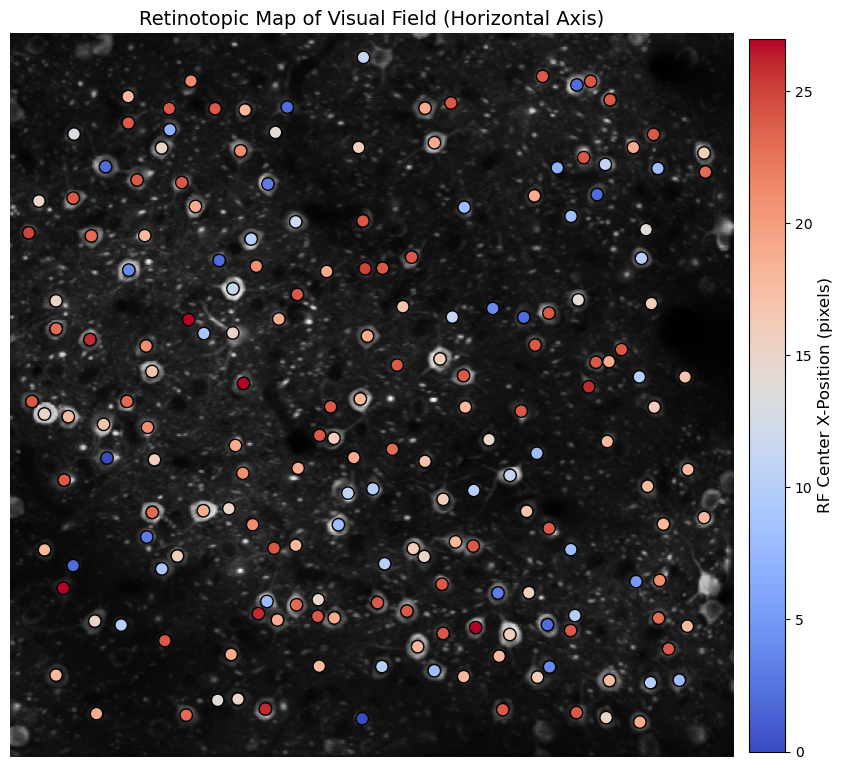

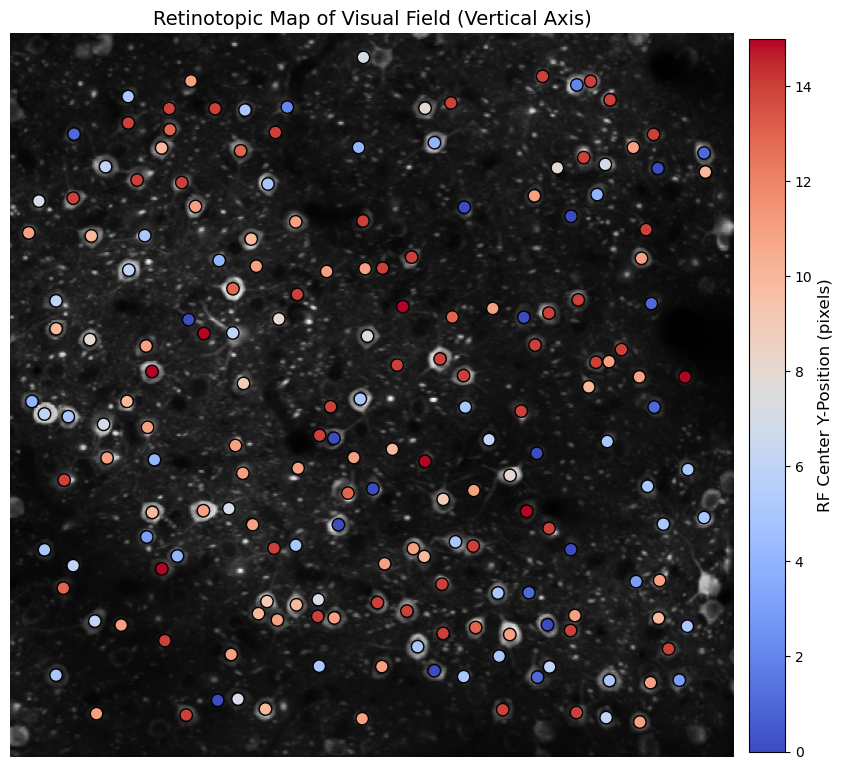

In [18]:
# Add this cell to your 04-statistical-testing.ipynb notebook

# --- Phase 4: Statistical Testing & Visualization ---
# Goal: Answer the main project question by mapping the functional
# properties (receptive fields) onto the anatomical locations (ROI masks).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils as U 
import importlib
import os

# Reload utils to ensure you're using the latest version of your functions
importlib.reload(U) 

print("Starting Phase 4: Final Analysis and Visualization...")

# --- Step 1: Load All Necessary Data ---

try:
    # ACTION: Change 'aakarsh' to your namespace if needed.
    namespace = "aakarsh" 
    
    # Load the original raw data to get ROI masks and max projection
    data = U.load_data() # Assuming the load_data function is in utils.py or defined
    roi_masks = data['roi_masks']
    max_projection_image = data['max_projection']

    # Load the output from the RF fitting notebook (03-tuning-function-fitting.ipynb)
    rf_fitting_dir = f'data/{namespace}/rf_fitting/'
    latest_rf_file = U.find_latest_file(rf_fitting_dir)
    print(f"Loading latest RF fitting data from: {latest_rf_file}")
    
    rf_data = np.load(latest_rf_file)
    all_rfs_spatial = rf_data['all_rfs_spatial']

except (FileNotFoundError, NameError) as e:
    print(f"ERROR: Could not find a necessary input file: {e}")
    print("Please ensure you have run the previous notebooks and saved their outputs correctly.")
    raise

# --- Step 2: Calculate Physical and Functional Locations ---

# Calculate the physical (x, y) coordinates for each neuron from its ROI mask
roi_centroids = U.calculate_roi_centroids(roi_masks)

# Calculate the functional (x, y) coordinates for each RF from the spatial maps
rf_centers = U.calculate_rf_centers(all_rfs_spatial)


# --- Step 3: Visualize the Retinotopic Map ---
# This is the key visualization that tests the project's hypothesis.
# We create two plots to map the horizontal (X) and vertical (Y) axes.

print("\nGenerating retinotopic maps...")

# Plot 1: Map of the horizontal (X) axis of the visual field
U.plot_retinotopic_map(
    roi_centroids=roi_centroids,
    rf_centers=rf_centers,
    background_image=max_projection_image,
    axis_to_map='x'
)

# Plot 2: Map of the vertical (Y) axis of the visual field
U.plot_retinotopic_map(
    roi_centroids=roi_centroids,
    rf_centers=rf_centers,
    background_image=max_projection_image,
    axis_to_map='y'
)


In [11]:

# --- Step 4: Save the Output of This Notebook ---
# This saves the results so you don't have to re-run this intensive step.
output_dir_rf = f'data/{namespace}/rf_fitting/'
if not os.path.exists(output_dir_rf):
    os.makedirs(output_dir_rf)

from datetime import datetime
run_date_prefix_current_time = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

output_path = os.path.join(
    output_dir_rf,
    f"neuron_rf_{run_date_prefix_current_time}.npz",
)
np.savez_compressed(
    output_path,
    all_rfs_spatiotemporal=np.array(all_rfs_spatiotemporal),
    all_rfs_spatial=np.array(all_rfs_spatial)
)
print(f"\nSuccessfully saved receptive field results to: {output_path}")


Successfully saved receptive field results to: data/aakarsh/rf_fitting/neuron_rf_2025_07_16_20_47_22.npz
